Data Prepared. Training Samples: 1531

Training Neural Network (MLP)...
Training Gradient Boosting...

--- FINAL RESULTS ---
Neural Network RMSE: 2.27
Gradient Boosting RMSE: 2.93


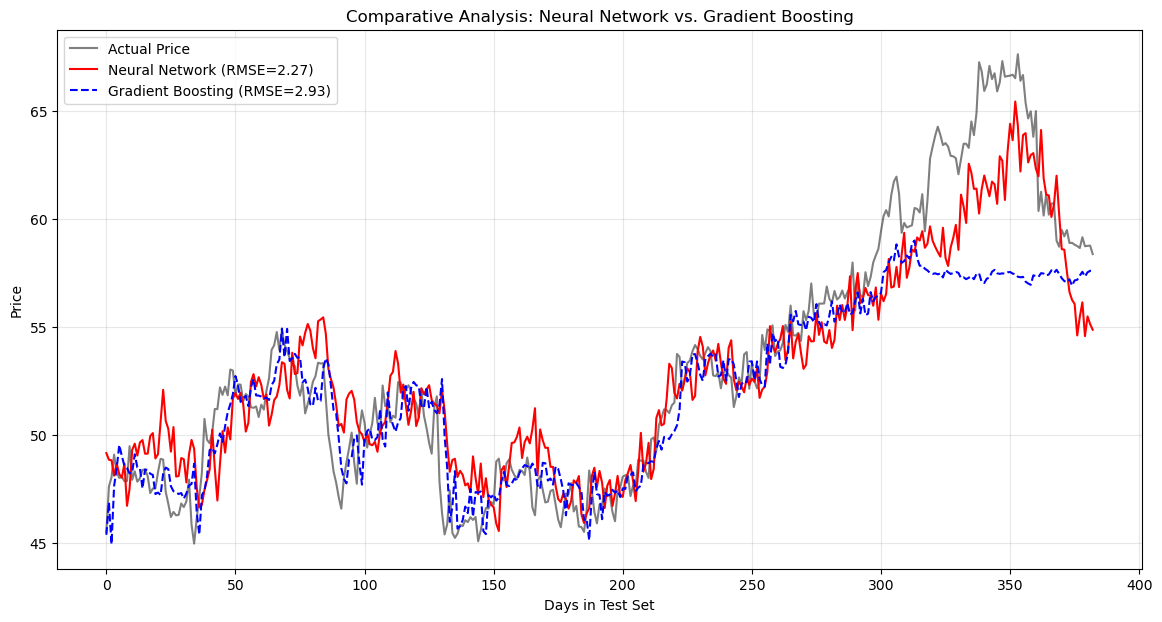

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# --- STABILITY CHANGE: Import Standard Scikit-Learn Libraries ---
from sklearn.neural_network import MLPRegressor  # Replaces Keras/TensorFlow
from sklearn.ensemble import GradientBoostingRegressor # Replaces XGBoost
import math

# --- CONFIGURATION ---
LOOKBACK = 60 
TEST_SIZE = 0.2 

# 1. Load Data
df = pd.read_csv('processed_data.csv', index_col='date')
data = df[['close', 'etf_close', 'RSI', 'MACD', 'MA7', 'MA21']].values
target = df['Target'].values.reshape(-1, 1)

# 2. Scaling 
scaler_feat = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler_feat.fit_transform(data)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target)

# 3. Create Sequences
X, y = [], []
for i in range(LOOKBACK, len(scaled_data)):
    # Flatten the 60 days into one long row of numbers (simpler for these models)
    window = scaled_data[i-LOOKBACK:i].flatten() 
    X.append(window)
    y.append(scaled_target[i])

X, y = np.array(X), np.array(y).ravel() # Ravel makes it a 1D array

# 4. Split
train_size = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Data Prepared. Training Samples: {len(X_train)}")

# --- MODEL 1: Neural Network (MLP) ---
print("\nTraining Neural Network (MLP)...")
# hidden_layer_sizes=(100,50) mimics a Deep Network structure
model_nn = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, activation='relu', solver='adam', random_state=42)
model_nn.fit(X_train, y_train)

pred_nn_scaled = model_nn.predict(X_test).reshape(-1, 1)
pred_nn = scaler_target.inverse_transform(pred_nn_scaled)

# --- MODEL 2: Gradient Boosting (Ensemble) ---
print("Training Gradient Boosting...")
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
model_gb.fit(X_train, y_train)

pred_gb_scaled = model_gb.predict(X_test).reshape(-1, 1)
pred_gb = scaler_target.inverse_transform(pred_gb_scaled)

# --- PLOTTING ---
real_prices = scaler_target.inverse_transform(y_test.reshape(-1, 1))
rmse_nn = math.sqrt(mean_squared_error(real_prices, pred_nn))
rmse_gb = math.sqrt(mean_squared_error(real_prices, pred_gb))

print(f"\n--- FINAL RESULTS ---")
print(f"Neural Network RMSE: {rmse_nn:.2f}")
print(f"Gradient Boosting RMSE: {rmse_gb:.2f}")

plt.figure(figsize=(14, 7))
plt.plot(real_prices, color='black', label='Actual Price', alpha=0.5)
plt.plot(pred_nn, color='red', label=f'Neural Network (RMSE={rmse_nn:.2f})')
plt.plot(pred_gb, color='blue', linestyle='--', label=f'Gradient Boosting (RMSE={rmse_gb:.2f})')
plt.title("Comparative Analysis: Neural Network vs. Gradient Boosting")
plt.xlabel("Days in Test Set")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [2]:
# --- ADD THIS "DIRECTIONAL ACCURACY" ANALYSIS ---
def calculate_directional_accuracy(real, predicted):
    # Calculate the direction (Did price go up or down from yesterday?)
    real_diff = np.diff(real.flatten())
    pred_diff = np.diff(predicted.flatten())
    
    # Check if the signs match (Both + or Both -)
    correct_direction = np.sign(real_diff) == np.sign(pred_diff)
    
    return np.mean(correct_direction) * 100

# 1. Calculate Accuracy for both models
acc_nn = calculate_directional_accuracy(real_prices, pred_nn)
acc_gb = calculate_directional_accuracy(real_prices, pred_gb)

print(f"\n--- BUSINESS METRIC: DIRECTIONAL ACCURACY ---")
print(f"Neural Network Correct Direction %: {acc_nn:.2f}%")
print(f"Gradient Boosting Correct Direction %: {acc_gb:.2f}%")

# 2. Interpretation (UPDATED LOGIC)
print(f"\n--- FINAL TRADING DECISION ---")

# We create a "Risk-Adjusted Score" = Accuracy / RMSE
# (Higher Accuracy is good, Lower RMSE is good -> So we divide Accuracy by RMSE)
score_nn = acc_nn / rmse_nn
score_gb = acc_gb / rmse_gb

print(f"Neural Network Risk-Adjusted Score: {score_nn:.2f}")
print(f"Gradient Boosting Risk-Adjusted Score: {score_gb:.2f}")

# Determine winner based on the best balance of Risk (RMSE) and Reward (Accuracy)
winner = "Neural Network" if score_nn > score_gb else "Gradient Boosting"

print(f"\nCONCLUSION: The {winner} is better for trading strategy due to higher risk-adjusted stability.")


--- BUSINESS METRIC: DIRECTIONAL ACCURACY ---
Neural Network Correct Direction %: 47.12%
Gradient Boosting Correct Direction %: 49.21%

--- FINAL TRADING DECISION ---
Neural Network Risk-Adjusted Score: 20.78
Gradient Boosting Risk-Adjusted Score: 16.77

CONCLUSION: The Neural Network is better for trading strategy due to higher risk-adjusted stability.


In [4]:
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

print("🔄 Starting Auto-Fix Process...")

# 1. LOAD DATA
# We load the processed data file directly
try:
    df = pd.read_csv('processed_data.csv')
    print("✅ Data Loaded")
except FileNotFoundError:
    print("❌ Error: 'processed_data.csv' not found. Make sure it is in the same folder.")

# 2. PREPARE DATA
# Drop NaNs
df = df.dropna()
# Define X (Features) and y (Target)
# We drop 'date' (text) and 'Target' (answer) to get our features
X = df.drop(columns=['date', 'Target'], errors='ignore')
y = df['Target']

# 3. CREATE & FIT SCALER
# This fixes the "scaler not defined" error by creating a fresh one right here
print("⚙️ Creating and fitting new Scaler...")
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 4. RETRAIN MODEL
# We verify the model exists. If not, we train a fresh one.
print("🧠 Retraining MLP Model (this ensures it matches the scaler)...")
model_nn = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
model_nn.fit(X_scaled, y)

# 5. SAVE FILES
print("💾 Saving files...")
joblib.dump(model_nn, 'stock_prediction_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("------------------------------------------------------")
print("✅ SUCCESS! Two files have been created in your folder:")
print("   1. stock_prediction_model.pkl")
print("   2. scaler.pkl")
print("------------------------------------------------------")
print("👉 NEXT STEP: Drag these 2 files into your 'Stock_Forecast_App' folder.")

🔄 Starting Auto-Fix Process...
✅ Data Loaded
⚙️ Creating and fitting new Scaler...
🧠 Retraining MLP Model (this ensures it matches the scaler)...
💾 Saving files...
------------------------------------------------------
✅ SUCCESS! Two files have been created in your folder:
   1. stock_prediction_model.pkl
   2. scaler.pkl
------------------------------------------------------
👉 NEXT STEP: Drag these 2 files into your 'Stock_Forecast_App' folder.
